# Data Ingestion Pipeline

### Loading npy(s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

In [3]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(zoom(voxelization,(1./2.,1./2.,1./2.)))
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [4]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Subvoxelgrid Transform
Che tipo di trasformazione bisogna applicare alla subvoxel grid estratta prima di utilizzarla?

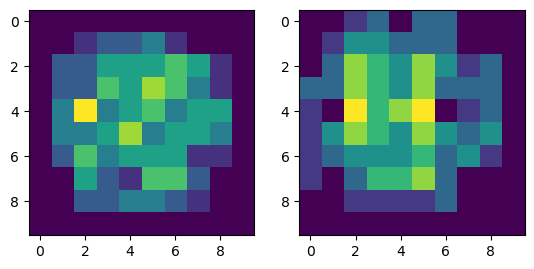

In [5]:
class SubvoxelgridTransform:
    def __init__(self,n):
        self.grid = self._init_grid(n)
        self.ball = self._emptyball(n)
    
    def _init_grid(self,n):
        return np.array(
        [
            [
                [
                    [x,y,z]
                    for z  in np.linspace(0,1,2*n)
                ]
                for y  in np.linspace(0,1,2*n)
            ]
            for x  in np.linspace(0,1,2*n)
        ]
        )

    def _emptyball(self,n):
        r = np.array([
            [
                [
                        (i**2 + j**2 + k**2) <= 1
                    for k in np.linspace(-1,1,2*n)
                ]
                for j in np.linspace(-1,1,2*n)
            ]
            for i in np.linspace(-1,1,2*n)
        ])
        return r
    
    ##############################################################################################
    
    def identity(self,SV):
        return SV
    
    
    def rotational_invariance(self,SV):
        # calcolo i nuovi punti
        points = self.grid[ (SV * self.ball) > 0.5].reshape(-1,3)
        if len(points) < 2.:
            # non ci sono atomi nella selezione!
            return SV

        points = points - points.mean(axis = 0)

        original_points = points.copy()

        U,s,Vt = np.linalg.svd(points)


        projection = points @ Vt.T
        classifica = np.argmax( np.abs(projection), axis = 0)
        S  =   np.sign( projection[classifica,[0,1,2]] )
        V  =   S[None,:] * Vt.T
        points = points @ V

        ## costruisco la voxelgrid
        ret  = np.zeros(self.grid.shape[:-1])

        stdpoints = (points - points.min()) / (points.max() - points.min())


        for p in stdpoints:
                i = int(p[0] * (SV.shape[0] - 1) )
                j = int(p[1] * (SV.shape[1] - 1) )
                k = int(p[2] * (SV.shape[2] - 1) )
                ret[i,j,k] = 1.
        return ret

A = np.random.uniform(size = (10,10,10))
axs = plt.figure().subplots(nrows = 1,ncols = 2).flatten()
axs[0].imshow(( (A>0.5) * SubvoxelgridTransform(5)._emptyball(5)).mean(axis = 0))
axs[1].imshow(SubvoxelgridTransform(5).rotational_invariance(A).mean(axis = 0))

# Batch extraction

In [6]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi    
                                len(voxelizations)     # il training set
                            )[indici_train] , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi
                                len(voxelizations)     # il test set
                            )[indici_test] , size = N  
                        )
    
    ####  Invarianza rotazionale
    
    transform = SubvoxelgridTransform(window_size)
    
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( transform.rotational_invariance 
                        (
                           curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] 
                        )
                      )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( 
                        transform.rotational_invariance 
                        (
                            curr_vox[ 
                                (i+window_size) - window_size: (i+window_size) + window_size,
                                (j+window_size) - window_size: (j+window_size) + window_size,
                                (k+window_size) - window_size: (k+window_size) + window_size
                              ] 
                        )
                        )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [7]:
def predict(W,Wf,X,F):
    O     = (
         jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
         jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
         jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
    ) < 4.
    Y_hat = jax.vmap(lambda x,f: (x*(W + O*(f @ Wf))).sum())(X,F)
    return Y_hat
def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = predict(W,Wf,X,F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward, argnums = (0,1)))

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [185]:
%matplotlib qt5

In [186]:
window = 9                # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048) * 1e-5 # small!
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(2000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    g  = grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    W  += 1e-1 * g[0]
    Wf += 1e-1 * g[1]
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 10 == 0:
        plt.show()
        plt.pause(1e-12)

0 -0.018289613 0.044924732
1 0.07292916 0.057959553
2 0.14619763 0.19379427
3 0.04370243 0.08753276
4 0.17635787 0.059493527
5 0.36085254 -0.014010701
6 0.047160204 -0.034515534
7 0.19652279 0.016497687
8 0.18736258 0.029064946
9 0.040931337 0.10334875
10 0.28225082 0.062458858
11 0.1835119 0.08743194
12 0.18228 0.06001141
13 0.20200032 0.08205455
14 0.034716412 0.11915715
15 0.18633957 0.20009404
16 0.20637207 0.13361926
17 0.16413234 -0.14515938
18 0.18037543 0.22790132
19 0.1670849 0.18752699
20 0.1609257 0.1739953
21 0.19401485 -0.06726624
22 0.28841764 0.13479078
23 0.21488883 0.19839185
24 0.34280482 0.15147856
25 0.297882 0.06730041
26 0.3622937 0.119043306
27 0.3134326 0.1586146
28 0.3114554 0.10135429
29 0.33139306 0.13933611
30 0.07404183 0.32517543
31 0.23365003 0.23208436
32 0.22580375 0.13918558
33 0.303322 0.21553525
34 0.19981706 0.3486311
35 0.21033777 0.15530545
36 0.17251296 0.22793233
37 0.2498292 0.2241048
38 0.1774487 0.15466091
39 0.28043503 0.24017684
40 0.191135

325 0.25706425 0.27280664
326 0.26537314 0.2540662
327 0.46390116 0.41062874
328 0.39787978 0.33114493
329 0.45609573 0.3265318
330 0.4074942 0.3299602
331 0.32615605 0.30910805
332 0.38380113 0.35013494
333 0.3278024 0.2617878
334 0.37540805 0.31653488
335 0.2819813 0.44672596
336 0.4422542 0.22626086
337 0.19858225 0.27098587
338 0.47015306 0.2037864
339 0.35325176 0.2873686
340 0.4053635 0.30229887
341 0.38124055 0.16985987
342 0.362782 0.4501041
343 0.5087522 0.14773127
344 0.33541355 0.2032124
345 0.42370063 0.22007543
346 0.4308081 0.2216579
347 0.42923257 0.2982949
348 0.4587419 0.21161436
349 0.38620594 0.18087739
350 0.407919 0.34783542
351 0.43499112 0.121110804
352 0.35134712 0.30565363
353 0.37154415 0.2292512
354 0.50320035 0.28232253
355 0.38526934 0.16940178
356 0.40728378 0.31840044
357 0.3982906 0.29887876
358 0.24353008 0.35750535
359 0.3506844 0.28730908
360 0.48963383 0.28700182
361 0.34954968 0.3106775
362 0.42726463 0.2303137
363 0.3388009 0.22030975
364 0.3404483

649 0.5138478 0.47592154
650 0.42781484 0.36979342
651 0.42944977 0.3591814
652 0.36889836 0.22849101
653 0.53473 0.40457466
654 0.35988358 0.3614519
655 0.39707348 0.4056401
656 0.41679156 0.41546217
657 0.37750268 0.23579969
658 0.5247304 0.30584452
659 0.40491962 0.31213364
660 0.48827076 0.27041057
661 0.43299106 0.34572026
662 0.3954982 0.3852587
663 0.39403662 0.33890167
664 0.4697207 0.22860192
665 0.33602625 0.2864464
666 0.49991202 0.41650426
667 0.4136232 0.2409979
668 0.45935145 0.3285656
669 0.51751804 0.37645426
670 0.41793856 0.26251844
671 0.39648956 0.30304152
672 0.35423338 0.35303286
673 0.42602137 0.3361237
674 0.36162096 0.41549522
675 0.39766854 0.4290877
676 0.41792592 0.29473194
677 0.42330167 0.28599212
678 0.4222073 0.38456944
679 0.4731094 0.31578326
680 0.4277052 0.3233863
681 0.4220596 0.44213274
682 0.42894462 0.29929107
683 0.52775323 0.278993
684 0.4088235 0.24985738
685 0.50538194 0.26765868
686 0.2593811 0.32273072
687 0.49454322 0.2553115
688 0.3487319

973 0.39720532 0.49083376
974 0.38843513 0.33136547
975 0.47773987 0.3435918
976 0.42754936 0.41386673
977 0.4970545 0.37766492
978 0.45077044 0.41257948
979 0.5063049 0.43461087
980 0.39140102 0.3376705
981 0.47305304 0.31198263
982 0.38011134 0.3956249
983 0.52165085 0.37724432
984 0.49461922 0.33345988
985 0.45735434 0.38787976
986 0.4625603 0.40375042
987 0.28505585 0.34783328
988 0.41975492 0.2850213
989 0.43457597 0.33398986
990 0.48483974 0.3568715
991 0.4243585 0.15547055
992 0.42526037 0.37488306
993 0.55319124 0.37582743
994 0.31247723 0.4085018
995 0.4481127 0.43962184
996 0.46856207 0.30436766
997 0.37658927 0.2617798
998 0.35695636 0.33668327
999 0.4245061 0.38193557
1000 0.46989694 0.31449002
1001 0.48665673 0.20017633
1002 0.52196944 0.37841266
1003 0.46373242 0.36464533
1004 0.34035626 0.3269709
1005 0.45699906 0.2984493
1006 0.4728257 0.3401966
1007 0.41080576 0.39017415
1008 0.4985607 0.31232056
1009 0.46812466 0.41028106
1010 0.42996895 0.3977259
1011 0.53112406 0.41

1286 0.4345416 0.37190694
1287 0.5097685 0.43731305
1288 0.47068876 0.27625605
1289 0.4543833 0.40041995
1290 0.42567372 0.45051864
1291 0.5543594 0.3685561
1292 0.45088404 0.34729582
1293 0.49556 0.32171687
1294 0.47301668 0.2769189
1295 0.3939001 0.3926443
1296 0.46329755 0.29236364
1297 0.5216967 0.32049468
1298 0.46616027 0.47782367
1299 0.4536788 0.33447814
1300 0.45894095 0.29311636
1301 0.40980932 0.43142098
1302 0.41609973 0.36483634
1303 0.44682983 0.46972287
1304 0.4314335 0.30855504
1305 0.503714 0.36178097
1306 0.48417044 0.36859345
1307 0.4821281 0.36430168
1308 0.47968453 0.40063626
1309 0.31099287 0.2621374
1310 0.3229429 0.22340594
1311 0.41332752 0.4366186
1312 0.4626553 0.39989844
1313 0.51952636 0.21135433
1314 0.46108708 0.26530054
1315 0.48221856 0.44403782
1316 0.40157998 0.33870327
1317 0.52975047 0.1504262
1318 0.4880958 0.48232356
1319 0.39690027 0.23011845
1320 0.32731882 0.36935788
1321 0.51282555 0.35075563
1322 0.43416584 0.36215365
1323 0.5144846 0.4602452

1599 0.4898703 0.33701944
1600 0.48894832 0.32714212
1601 0.39498168 0.24875353
1602 0.5236497 0.43787292
1603 0.5366459 0.41978306
1604 0.44766587 0.37219962
1605 0.48800072 0.36031327
1606 0.44520476 0.36470738
1607 0.4521961 0.32950705
1608 0.42558965 0.4290709
1609 0.4522637 0.33485916
1610 0.46132967 0.3937187
1611 0.40485474 0.3635962
1612 0.43692243 0.4407358
1613 0.4954163 0.2737414
1614 0.42420766 0.46412644
1615 0.45878574 0.47643244
1616 0.4818025 0.39276284
1617 0.5632653 0.36815497
1618 0.48427033 0.42247027
1619 0.43923295 0.28395778
1620 0.5352052 0.40944
1621 0.4408842 0.5126571
1622 0.4650723 0.4085916
1623 0.36464486 0.33520743
1624 0.52825266 0.49697256
1625 0.54145056 0.3269828
1626 0.4763166 0.29478228
1627 0.4936501 0.2316989
1628 0.51694566 0.40235144
1629 0.47269106 0.28290945
1630 0.5136158 0.2920298
1631 0.44341832 0.4605641
1632 0.42566428 0.41975212
1633 0.39803284 0.44688046
1634 0.4148306 0.26161298
1635 0.48545069 0.4284612
1636 0.39328945 0.32241192
1637

1912 0.44612825 0.25784317
1913 0.33596727 0.42382365
1914 0.4400613 0.47612393
1915 0.4281717 0.37167534
1916 0.39480954 0.41202304
1917 0.39813986 0.3739643
1918 0.52495605 0.46546876
1919 0.54510665 0.4048048
1920 0.42561606 0.3449928
1921 0.5315167 0.29416078
1922 0.4221352 0.46989584
1923 0.4936585 0.3495804
1924 0.5608023 0.41986653
1925 0.55327696 0.32574403
1926 0.46626058 0.18983392
1927 0.52547246 0.40832248
1928 0.50937504 0.28250065
1929 0.52545923 0.43744874
1930 0.3765692 0.39972794
1931 0.50848573 0.41165358
1932 0.40133306 0.51646566
1933 0.5602879 0.41983232
1934 0.45764697 0.35252747
1935 0.47586384 0.29983756
1936 0.4392256 0.3775597
1937 0.4936782 0.37258193
1938 0.40673572 0.33133677
1939 0.4251273 0.4453537
1940 0.4697563 0.32232353
1941 0.4427963 0.43929583
1942 0.53161186 0.368444
1943 0.5923486 0.46545807
1944 0.49244595 0.46364415
1945 0.4589723 0.38817915
1946 0.4664396 0.32689473
1947 0.48391274 0.37725964
1948 0.5519098 0.31926653
1949 0.51266205 0.48535225

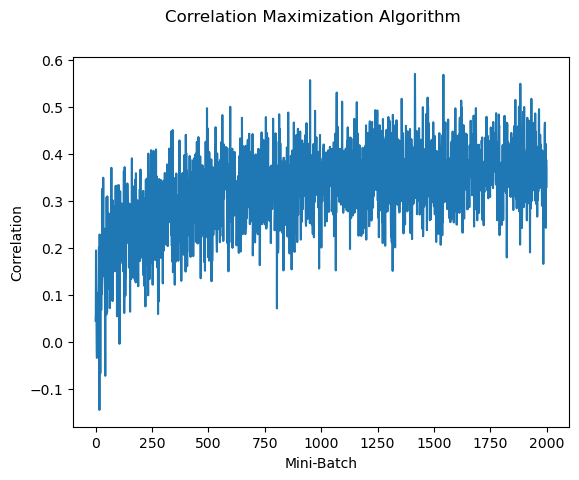

In [187]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Salvo i pesi

In [188]:
np.save("W_%d.npy" % window, W)
np.save("Wf_%d.npy" % window, Wf)

# Carico i pesi

In [8]:
window = 9
W  = np.load("W_%d.npy" % window)
Wf = np.load("Wf_%d.npy" % window)

# Test (singolo)

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

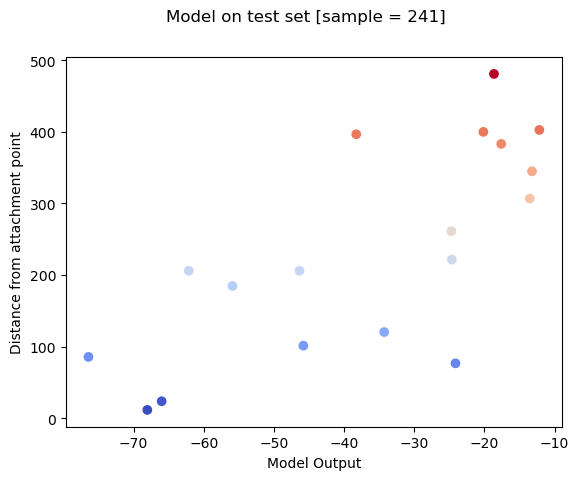

In [9]:
sample = np.arange(len(voxelizations))[indici_test][1]

def prediction_compare(sample):
    # dato un sample ritorna una matrice la cui prima colonna
    # rappresenta l'output del modello mentre la seconda
    # é la vera "inadeguatezza" degli anchor point
    
    
    # costrusico la voxgrid paddata
    Nx,Ny,Nz  = voxelizations[sample].shape
    curr_vox  = jnp.pad(
                    voxelizations[sample],
                    pad_width = (
                        (window,window),
                        (window,window),
                        (window,window)
                    )
                )

    # imposto la trasfromazione

    transform = SubvoxelgridTransform(window)

    points = []
    for a in anchors[sample]:
        correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )

        # trovo il voxel associato al punto di ancoraggip
        x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
        x,y,z = a
        i,j,k = (
                 int( (x - x_min)/(x_max - x_min) * Nx ),
                 int( (y - y_min)/(y_max - y_min) * Ny ),
                 int( (z - z_min)/(z_max - z_min) * Nz )
        )

        # estraggo la subvoxelgrid
        subvox = transform.rotational_invariance(curr_vox[ 
                                (i+window) - window: (i+window) + window,
                                (j+window) - window: (j+window) + window,
                                (k+window) - window: (k+window) + window
                              ])
        # estraggo il farmaco
        f      = finger_prints[sample]
        Y_hat =  predict(W,Wf,subvox[None,:],f[None,:])[0]

        points.append([Y_hat,correct_distance])

    points = np.array(points)
    return points

points = prediction_compare(sample)
plt.xlabel("Model Output")
plt.ylabel("Distance from attachment point")
plt.suptitle("Model on test set [sample = %d]" % sample)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)

# Test Globale

Il nostro modello produce fondamentalmente una "classifica" di bontá degli anchor points.
Per valutare la bontá del modello produciamo una confusion matrix definita in questo modo

Dato un set di <b>Anchor Points</b> $A$ e u Definiamo $C_{A,t} : A \rightarrow \{0,1\}$ la funzione che restituisce $0$ se l'anchor point é tra i primi $t$ piú vicini al punto di attachment, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza. <br>
<br>
<i>
<b> Definizione </b> (buon anchor point): Dato un set di anchor points $A$ e una soglia $t \in [1,|A|]$, $a \in A$ é detto un <b> buon anchor point se nella $C_{A,t}(a) = 0$</b> 
</i>
<br>
<br>
Parallelamente definiamo $\hat C_{A,t} : A \rightarrow \{0,1\}$ la funzione che, analogamente, resituisce $0$ se l'anchor point in ingresso é <b> predetto dal modello </b> come tra i primi $t$ piú vicini, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza <b> predetta</b>


<br>
Per valutare la bontá del nostro modello possiamo considerare la matrice $M$ cosí definita
<br><br>
<center>
$M^{(t)}_{ij} = \mathbb P[ \hat C_{A,t}(a) = i | C_{A,t}(a) = j  ]$
</center>
<br>
Che ha come elementi sulla diagonale le probabilitá di dare un risultato corretto in funzione del vero set di appartenenza dell'anchor point

In [262]:
soglia = 8

<AxesSubplot:>

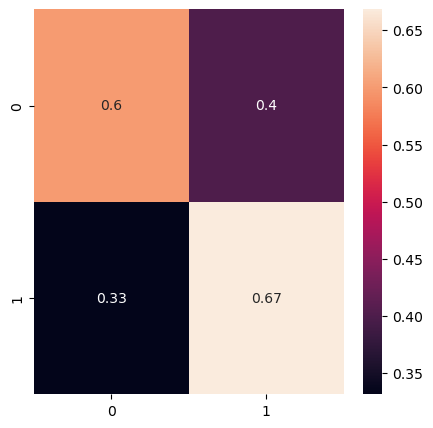

In [263]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

# Comparazione con Oracolo Randomico

Si definisce un <b>oracolo randomico</b> come una funzione $\mathscr O$ che prende in ingresso una <b> lista di anchor points </b> e restituisce <b> una classifica casuale </b>. <br>
Come ad esempio

In [264]:
def oracolo(A):
    classifica = np.random.choice(len(A),len(A),False)
    return classifica

Applichiamo lo stesso test globale sull'oracolo randomico per comparare le matrici di confusione

<AxesSubplot:>

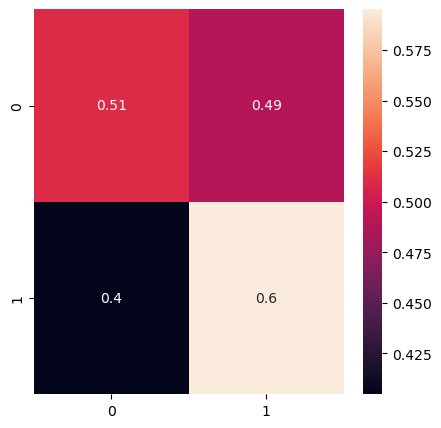

In [265]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    points[:,0] = oracolo(np.arange(len(points)))
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

Si osservi che gli elementi sulla diagonale risultano inferiori rispetto all'esperimento basato sul modello. Questo a riprova del fatto che il modello é in grado di mappare buoni anchor point in predizioni positive

# One-choice Test

Un test piú intuitivo, che rappresenta meglio il caso di uso pratico dell'algoritmo é il <b> one-choice test </b>

<b> Definizione: </b> (One-choice test) Si definisce come One-choice il confronto tra le stime di probabilitá di selezionare un <b> buon anchor point </b> usando una policy casuale rispetto alla stima di probabilitá di selezionare un buon anchor point usando la policy definita implicitamente dal modello

<b> Definizione: </b> (Policy definita da un modello) Sia $\hat m$ un modello che prende in ingresso anchor points e restituisce una classifica. La policy definita dal modello ritorna con probabilitá $1$ il primo anchor point in classifica

<b> Remark </b> (Policy per un oracolo randomico) Dal momento che il modello rappresentato dall'oracolo randomico $\mathscr O$ restituisce una permutazione casuale degli anchor points come classifica, il primo in classifica é un anchor point casuale (con probabilitá di estrazione equidistribuita tra i vari anchor points)

Testiamo la bontá della predizione misurando la probabilitá che il migliore predetto dal modello sia tra i primi $t$.<br>
Definiamo lo stimatore $J$ tale che
<br><br>
<center>
$
J(\hat y)
\sim
\underbrace{
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
}_{\text{Selezionato dal modello}}    
   \in 
   \overbrace{ 
       A|_{C_{A,t}(A) = 0 }
   }^{
   \text{"Buoni" anchor point}
   }
$
</center>
Si osservi che <br>
<center>
    $\mathbb E[J(\hat y)] = \mathbb P [
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
   \in 
       A|_{C_{A,t}(A) = 0 }
]$
</center>

Chiamando nuovamente $\mathscr O$ l'oracolo randomico, vogliamo confrontare le variabili aleatorie $J(\hat y)$ e $J(\mathscr O)$<br> 
In particolare siamo interessati a valutare $\mathscr I(\hat y,\mathscr O) = J(\hat y) - J(\mathscr O)$  ovvero la variabile aleatoria che ci informa circa il miglioramento portato dal nostro algoritmo rispetto a una scelta casuale

In [269]:
test_samples = np.arange(len(voxelizations))[indici_test]

J = []
J_oracolo = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 500,replace = True)]):
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    scelto      = points[:,1][points[:,0].argmin()]
    curr_soglia = 2
    J.append( scelto < curr_soglia )
    scelto_rnd  = points[:,1][np.random.choice(len(points))]
    J_oracolo.append(scelto_rnd < curr_soglia)
print("Stima eseguita.")

Stimando J(y) e J(O)...
Stima eseguita.


Si osservi come la probabilitá di selezionare un <b> buon anchor point </b> risulti mediamente piú alta usando il modello

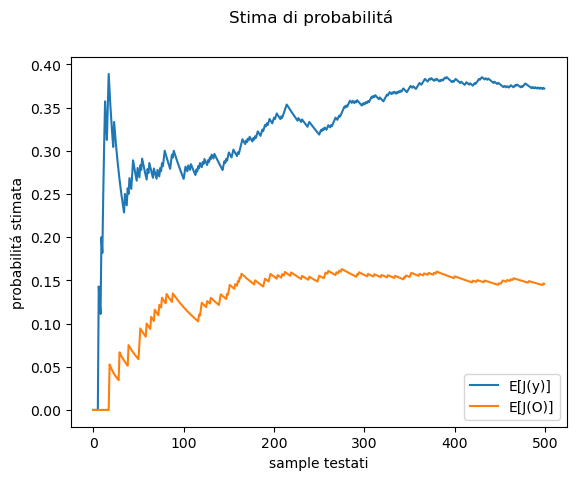

In [270]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("probabilitá stimata")
plt.plot( np.cumsum(np.array(J))/(np.arange(len(J)) +1) )
plt.plot( np.cumsum(np.array(J_oracolo))/(np.arange(len(J_oracolo)) +1) )
plt.legend(['E[J(y)]','E[J(O)]'])
plt.show()

Possiamo anche visualizzare la stima per $\mathbb E[ \mathscr I(\hat y,\mathscr O) ]$

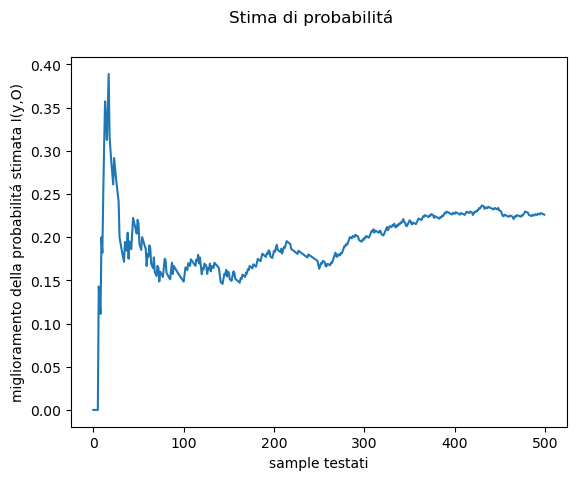

In [271]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("miglioramento della probabilitá stimata I(y,O)")
plt.plot( np.cumsum(np.array(J)*1 - 1*np.array(J_oracolo))/(np.arange(len(J)) +1) )
plt.show()

# Average Amount of Attempts Test
Immaginiamo di avere una funzione $h_A : A \rightarrow \{0,1\}$ che restituisce $1$ se l'anchor point é quello piu vicino al punto di attachment, viceversa 0.
Testiamo quanti tentativi ci vogliono - mediamente - per trovare l'anchor point $a$ tale che $h_A(a) = 1$ usando rispettivamente la policy indotta dal nostro modello e la policy dell'oracolo casuale. (nella policy indotta dal modello partiamo da quelli predetti come piu vicini e li testiamo in ordine crescente, nella policy dell'oracolo casuale semplicemente tentiamo a caso)

In [21]:
def prediction_compare_oracolo(A,sample):
    classifica = np.random.choice(len(A),len(A),False)
    return np.c_[classifica, [ np.linalg.norm(c - A[c]) for c in classifica] ]

In [55]:
test_samples = np.arange(len(voxelizations))[indici_test]

tentativi           = []
tentativi_oracolo   = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 1000,replace = True)]):
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    
    print(i)
    
    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_curr =  ( (points[:,1] == 0).argmax() )
    tentativi.append(  (tentativi_curr * 1.) / len(points) )
    
    ############################################################
    
    points      = prediction_compare_oracolo(anchors[sample],sample)
    points      = points.argsort(axis = 0)

    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_oracolo_curr =  ( (points[:,1] == 0).argmax() )
    tentativi_oracolo.append( (tentativi_oracolo_curr * 1.) / len(points) )
    
print("Stima eseguita.")

Stimando J(y) e J(O)...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
27

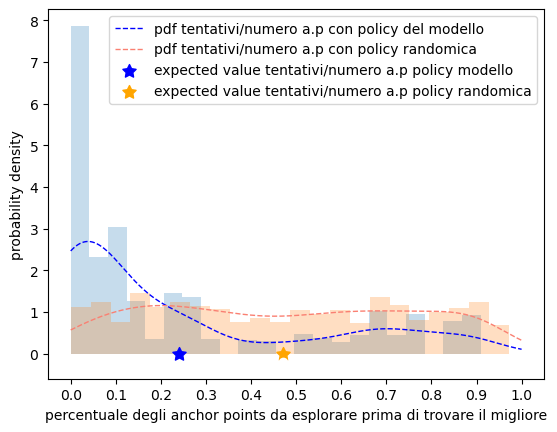

In [87]:
from scipy import stats
plt.xticks(np.linspace(0,1,11))
plt.hist(np.array(tentativi), alpha = 0.25, bins = int(np.sqrt(500)), density = True)
plt.hist(tentativi_oracolo, alpha = 0.25, bins = int(np.sqrt(500)), density = True)
kde = stats.gaussian_kde(tentativi)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx), '--', color = 'blue', lw = 1.)

kde = stats.gaussian_kde(tentativi_oracolo)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx),'--', color = 'salmon', lw = 1.)
plt.ylabel("probability density")
plt.xlabel("percentuale degli anchor points da esplorare prima di trovare il migliore")

plt.scatter( np.mean(tentativi), 0 , color = 'blue', marker = (5,1), s = 100)
plt.scatter( np.mean(tentativi_oracolo), 0 , color = 'orange', marker = (5,1), s = 100)

plt.scatter( np.mean(tentativi_oracolo), -.2 , color = 'white') # dumb scatter point
plt.legend(['pdf tentativi/numero a.p con policy del modello',
            'pdf tentativi/numero a.p con policy randomica',
            'expected value tentativi/numero a.p policy modello',
            'expected value tentativi/numero a.p policy randomica'
           ])
plt.show()
